# Exercise 6: Ticket Triaging Agentic AI System

In [1]:
#pip install langgraph langchain langchain-openai

  Using cached langchain_core-0.3.83-py3-none-any.whl.metadata (3.2 kB)
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
  Using cached langgraph_checkpoint-4.0.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached langgraph_checkpoint-3.0.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_checkpoint-2.1.2-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_checkpoint-2.1.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_checkpoint-2.1.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached langchain_text_splitters-0.3.11-py3-none-any.whl.metadata (1.8 kB)
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide th

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.128 requires chromadb<0.6.0,>=0.5.10, but you have chromadb 1.3.7 which is incompatible.
embedchain 0.1.128 requires langchain<0.4.0,>=0.3.1, but you have langchain 1.2.7 which is incompatible.
embedchain 0.1.128 requires langchain-community<0.4.0,>=0.3.1, but you have langchain-community 0.4.1 which is incompatible.
embedchain 0.1.128 requires langchain-openai<0.3.0,>=0.2.1, but you have langchain-openai 1.1.7 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from __future__ import annotations

from datetime import datetime
from difflib import SequenceMatcher
from pathlib import Path
from typing import TypedDict, List, Optional, Literal

import json
import textwrap

from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore

from dotenv import load_dotenv
_ = load_dotenv()

In [4]:
# ========= 1. State =========

class TicketState(TypedDict, total=False):
    ticket_sender: str
    ticket_timestamp: str
    ticket_desc: str
    urgency: Optional[int]
    category: Optional[str]
    errors: List[str]

    kb_context: str
    kb_answer: str

    faq_match: Optional[dict]
    past_match: Optional[dict]
    customer_profile: Optional[dict]

    routing_decision: str
    assignee_team: Optional[str]
    suggested_reply: Optional[str]
    triage_summary: Optional[str]


# ========= 2. LLM & Embeddings =========

llm = ChatOpenAI(model="gpt-4o", temperature=0.1)
EMBEDDINGS = OpenAIEmbeddings(model="text-embedding-3-small")

In [5]:
# ========= 3. Unstructured KB (RAG over kb_nj_redcross.txt) =========

KB_TEXT_PATH = Path("kb_nj_redcross.txt")

def load_kb_entries() -> List[Document]:
    text = KB_TEXT_PATH.read_text(encoding="utf-8")
    raw_entries = [e.strip() for e in text.split("\n\n") if e.strip()]
    docs: List[Document] = []
    for entry in raw_entries:
        lines = entry.splitlines()
        title = lines[0].strip()
        body = "\n".join(lines[1:]).strip()
        docs.append(
            Document(
                page_content=body,
                metadata={"title": title}
            )
        )
    return docs

def build_kb_vectorstore() -> InMemoryVectorStore:
    docs = load_kb_entries()
    vs = InMemoryVectorStore.from_documents(
        documents=docs,
        embedding=EMBEDDINGS,
    )
    return vs

VECTORSTORE = build_kb_vectorstore()
RETRIEVER = VECTORSTORE.as_retriever(search_kwargs={"k": 3})


# ========= 4. Structured KB (JSON) =========

STRUCTURED_KB_PATH = Path("kb_structured.json")
STRUCTURED_KB = json.loads(STRUCTURED_KB_PATH.read_text(encoding="utf-8"))

def best_faq_match(query: str, threshold: float = 0.6):
    best = None
    best_score = 0.0
    for faq in STRUCTURED_KB["faqs"]:
        score = SequenceMatcher(None, query.lower(), faq["q"].lower()).ratio()
        if score > best_score:
            best_score, best = score, faq
    return best if best_score >= threshold else None

def best_past_resolution(category: str | None):
    if not category:
        return None
    cat_map = {
        "Aid Requests": "Aid",
        "Volunteer": "Volunteer",
        "Donations/Billing": "Donations",
        "Tech Support": "Tech",
        "General Info": "General",
    }
    target = cat_map.get(category, None)
    if not target:
        return None
    for t in STRUCTURED_KB["past_resolutions"]:
        if t["category"] == target:
            return t
    return None

def customer_profile(sender: str):
    for c in STRUCTURED_KB["customer_history"]:
        first = c["name"].split()[0].lower()
        if first in sender.lower():
            return c
    return None

In [6]:
# ========= 5. Parsing helper =========
def parse_ticket_input(ticket_data: dict) -> TicketState:
    state: TicketState = {}
    state["ticket_sender"] = ticket_data.get("sender", "Unknown")

    state["errors"] = []

    ts_str = ticket_data.get("timestamp", "")
    if ts_str:
        try:
            state["ticket_timestamp"] = datetime.fromisoformat(
                ts_str.replace("Z", "+00:00")
            ).strftime("%Y-%m-%d %H:%M")
        except ValueError:
            state["ticket_timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M")
            state["errors"].append("Invalid timestamp format")
    else:
        state["ticket_timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M")
        state["errors"].append("Missing timestamp")

    # Description: if missing, keep it empty but DO NOT mark as parsing error
    desc = ticket_data.get("body", ticket_data.get("text", "")).strip()
    state["ticket_desc"] = desc[:1000] if desc else ""

    state["urgency"] = None
    state["category"] = None

    return state

# ========= 6. Nodes =========
def input_processor(state: TicketState) -> TicketState:
    sender = state.get("ticket_sender", "Unknown")
    ts = state.get("ticket_timestamp", "Unknown time")
    desc = state.get("ticket_desc", "")

    print(f"\n📥 Processing ticket from {sender} at {ts}:")
    print(f"   Description: {desc[:200]}...")

    errors = state.get("errors", [])
    if errors:
        print(f"⚠️  Errors: {', '.join(errors)}")

    # Do NOT change description here
    return state

def error_handler(state: TicketState) -> TicketState:
    errors = state.get("errors", [])
    print("🚨 Error handler node reached.")
    print("   Errors:", errors)

    state["category"] = state.get("category") or "General Info"
    state["urgency"] = state.get("urgency") or 1
    state["triage_summary"] = "Ticket had parsing errors; routed to General Info with low urgency."
    state["suggested_reply"] = (
        "We’re sorry, but we could not fully understand your request. "
        "Could you please provide more details so we can help you better?"
    )
    return state


def classify_node(state: TicketState) -> TicketState:
    desc = state.get("ticket_desc", "")

    prompt = f"""
You are triaging support tickets for NJ RedCross Aid Network.

Classify the ticket into:
- Category: one of [Aid Requests, Volunteer, Donations/Billing, Tech Support, General Info]
- Urgency: integer 1-5
  1 = Low (info, non-urgent)
  2 = Medium-Low (routine follow-up)
  3 = Medium (needs action soon)
  4 = High (time-sensitive, event-related)
  5 = Critical (immediate risk to safety/shelter/health)

Ticket:
\"\"\"{desc}\"\"\"

CRITICAL: Return ONLY a raw JSON object.
- Do NOT include markdown code blocks (```json).
- Do NOT include any explanations, preamble, or trailing text.
- Ensure the output begins with {{ and ends with }}.

Valid example:
{{"category": "Aid Requests", "urgency": 5}}
"""
    resp = llm.invoke(textwrap.dedent(prompt))

    try:
        data = json.loads(resp.content)
        state["category"] = data.get("category")
        state["urgency"] = int(data.get("urgency", 3))
    except Exception as e:
        print("❌ Failed to parse LLM classification, fallback General Info / 3:", resp.content)
        state["category"] = "General Info"
        state["urgency"] = 3

    print(f"✅ Classified -> Category: {state['category']}, Urgency: {state['urgency']}")
    return state


def research_node(state: TicketState) -> TicketState:
    query = state.get("ticket_desc", "")
    if not query or query == "Invalid ticket - insufficient details.":
        print("ℹ️ Research skipped: no valid description.")
        state["kb_context"] = ""
        state["kb_answer"] = ""
        return state

    docs = RETRIEVER.invoke(query)
    context_blocks = []
    for d in docs:
        title = d.metadata.get("title", "")
        context_blocks.append(f"{title}\n{d.page_content}")
    kb_context = "\n\n---\n\n".join(context_blocks)

    print("\n🔎 Research agent retrieved KB entries:")
    for d in docs:
        print(" •", d.metadata.get("title"))

    prompt = f"""
You are a support assistant for NJ RedCross Aid Network.
You are given a ticket and related knowledge base entries. 
Use ONLY the information in the KB to suggest how a human agent should respond.

Ticket:
\"\"\"{query}\"\"\"

Knowledge Base:
\"\"\"{kb_context}\"\"\"

Write a concise recommendation for the support agent: what to do and what to say to the customer.
Start with 1-2 bullet points of actions, then a short reply template.
"""
    resp = llm.invoke(textwrap.dedent(prompt))
    kb_answer = resp.content.strip()

    state["kb_context"] = kb_context
    state["kb_answer"] = kb_answer
    return state


def enrich_with_structured_kb(state: TicketState) -> TicketState:
    desc = state.get("ticket_desc", "")
    state["faq_match"] = best_faq_match(desc)
    state["past_match"] = best_past_resolution(state.get("category"))
    state["customer_profile"] = customer_profile(state.get("ticket_sender", ""))
    return state


def routing_node(state: TicketState) -> TicketState:
    desc = state.get("ticket_desc", "")
    category = state.get("category")
    urgency = state.get("urgency") or 3
    faq = state.get("faq_match")
    past = state.get("past_match")
    kb_answer = state.get("kb_answer", "")
    profile = state.get("customer_profile")

    # Heuristic: if there is little/no description, we need more info
    # (but we got here, so parsing was OK)
    if not desc or len(desc.split()) < 5:
        decision = "need_more_info"
    elif faq and urgency <= 2:
        decision = "auto_resolve"
    elif urgency >= 5:
        decision = "escalate"
    elif urgency == 4:
        decision = "assign_team"
    else:
        decision = "draft_response"

    state["routing_decision"] = decision

    cat_to_team = {
        "Aid Requests": "Aid Response Team",
        "Volunteer": "Volunteer Coordination",
        "Donations/Billing": "Donor Support",
        "Tech Support": "IT Support",
        "General Info": "Community Info Desk",
    }
    assignee_team = cat_to_team.get(category, "General Queue")
    state["assignee_team"] = assignee_team

    faq_str = f"FAQ match: {faq}" if faq else "FAQ match: None"
    past_str = f"Past ticket: {past}" if past else "Past ticket: None"
    profile_str = f"Customer profile: {profile}" if profile else "Customer profile: None"

    prompt = f"""
You are a routing agent for NJ RedCross Aid Network.

Your job:
1) Given a ticket, classification, KB research, and decision, create:
   - a short triage summary for the internal support tool
   - a suggested reply message to the customer.

Ticket description:
\"\"\"{desc}\"\"\"

Category: {category}
Urgency: {urgency}
Routing decision: {decision}
Assignee team: {assignee_team}

RAG KB answer:
\"\"\"{kb_answer}\"\"\"

Structured KB context:
{faq_str}
{past_str}
{profile_str}

Output JSON only with:
{{
  "triage_summary": "...",
  "suggested_reply": "..."
}}
"""
    resp = llm.invoke(textwrap.dedent(prompt))

    try:
        data = json.loads(resp.content)
        state["triage_summary"] = data.get("triage_summary", "")
        state["suggested_reply"] = data.get("suggested_reply", "")
    except Exception:
        state["triage_summary"] = f"{decision} for {assignee_team} - {category} / {urgency}"
        state["suggested_reply"] = (
            "Thank you for contacting NJ RedCross. We are reviewing your request."
        )

    return state


def ask_more_info_node(state: TicketState) -> TicketState:
    print("Came to ask more info")
    desc = state.get("ticket_desc", "")
    print("\n❓ Need more info for ticket:", desc)

    prev = state.get("triage_summary", "")
    if prev:
        prev += " | "
    state["triage_summary"] = prev + "Missing info, requested clarification from customer."
    state["suggested_reply"] = (
        "Thanks for reaching out to NJ RedCross. To assist you better, could you please provide "
        "a bit more detail about your situation (location, number of people affected, and urgency)?"
    )
    return state

In [7]:
# ========= 7. Routing helpers for conditional edges =========

def route_after_input(state: TicketState) -> Literal["error_handler", "classify"]:
    errors = state.get("errors", [])
    if errors:
        return "error_handler"
    return "classify"

def route_after_routing(state: TicketState) -> Literal["ask_more_info", "done"]:
    if state.get("routing_decision") == "need_more_info":
        return "ask_more_info"
    return "done"


# ========= 8. Build graph =========

builder = StateGraph(TicketState)

builder.add_node("input_processor", input_processor)
builder.add_node("error_handler", error_handler)
builder.add_node("classify", classify_node)
builder.add_node("research", research_node)
builder.add_node("enrich_structured", enrich_with_structured_kb)
builder.add_node("routing", routing_node)
builder.add_node("ask_more_info", ask_more_info_node)

builder.add_edge(START, "input_processor")

builder.add_conditional_edges(
    "input_processor",
    route_after_input,
    {
        "error_handler": "error_handler",
        "classify": "classify",
    },
)

builder.add_edge("error_handler", END)
builder.add_edge("classify", "research")
builder.add_edge("research", "enrich_structured")
builder.add_edge("enrich_structured", "routing")

builder.add_conditional_edges(
    "routing",
    route_after_routing,
    {
        "ask_more_info": "ask_more_info",
        "done": END,
    },
)

builder.add_edge("ask_more_info", END)

app = builder.compile()

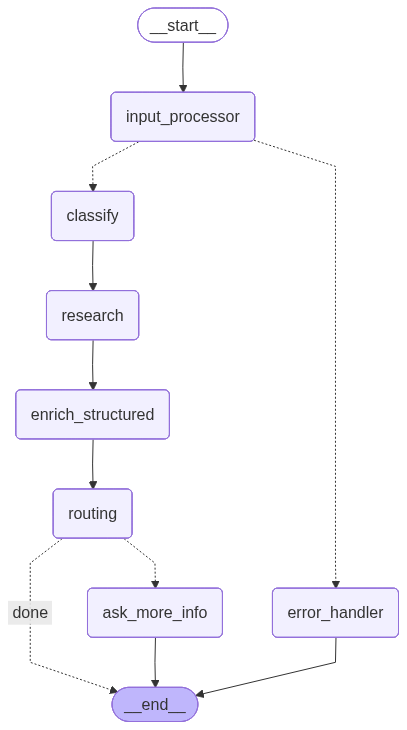

In [8]:
from IPython.display import display, Image

# Visualize the agent's decision-making flow
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
# ========= 9. Demo run =========

if __name__ == "__main__":
    # Example: valid, high-urgency aid ticket
    sample_ok = {
        "sender": "John Doe <john.doe@email.com>",
        "timestamp": "2026-01-27T10:30:00Z",
        "body": "House flooded in Princeton Junction storm last night. "
                "Family of 4 homeless, need shelter and food ASAP.",
    }

    initial_state = parse_ticket_input(sample_ok)
    print("initial_state:", initial_state)

    final_state = app.invoke(initial_state)
    print("\n=== FINAL STATE ===")
    for k, v in final_state.items():
        print(f"{k}: {v}")

initial_state: {'ticket_sender': 'John Doe <john.doe@email.com>', 'errors': [], 'ticket_timestamp': '2026-01-27 10:30', 'ticket_desc': 'House flooded in Princeton Junction storm last night. Family of 4 homeless, need shelter and food ASAP.', 'urgency': None, 'category': None}

📥 Processing ticket from John Doe <john.doe@email.com> at 2026-01-27 10:30:
   Description: House flooded in Princeton Junction storm last night. Family of 4 homeless, need shelter and food ASAP....
✅ Classified -> Category: Aid Requests, Urgency: 5

🔎 Research agent retrieved KB entries:
 • [KB1] Flood shelter process
 • [KB9] Eligibility for disaster aid
 • [KB3] Emergency contact hotline

=== FINAL STATE ===
ticket_sender: John Doe <john.doe@email.com>
ticket_timestamp: 2026-01-27 10:30
ticket_desc: House flooded in Princeton Junction storm last night. Family of 4 homeless, need shelter and food ASAP.
urgency: 5
category: Aid Requests
errors: []
kb_context: [KB1] Flood shelter process
If a family reports home 

In [30]:
# Example: missing description -> error_handler
sample_bad = {
    "sender": "no.desc@example.com",
    "timestamp": "2026-01-27T10:30:00Z"
}
initial_bad = parse_ticket_input(sample_bad)
print("\ninitial_state (BAD):", initial_bad)
final_bad = app.invoke(initial_bad)
print("\n=== FINAL STATE (BAD) ===")
for k, v in final_bad.items():
    print(f"{k}: {v}")


initial_state (BAD): {'ticket_sender': 'no.desc@example.com', 'errors': [], 'ticket_timestamp': '2026-01-27 10:30', 'ticket_desc': '', 'urgency': None, 'category': None}

📥 Processing ticket from no.desc@example.com at 2026-01-27 10:30:
   Description: ...
✅ Classified -> Category: General Info, Urgency: 1
ℹ️ Research skipped: no valid description.
Came to ask more info

❓ Need more info for ticket: 

=== FINAL STATE (BAD) ===
ticket_sender: no.desc@example.com
ticket_timestamp: 2026-01-27 10:30
ticket_desc: 
urgency: 1
category: General Info
errors: []
kb_context: 
kb_answer: 
faq_match: None
past_match: {'ticket_id': 'T112', 'category': 'General', 'urgency': 1, 'summary': 'Classes info.', 'resolution': 'Linked schedule; no RSVP needed.'}
customer_profile: None
routing_decision: need_more_info
assignee_team: Community Info Desk
suggested_reply: Thanks for reaching out to NJ RedCross. To assist you better, could you please provide a bit more detail about your situation (location, numb

In [34]:
# Example: missing description -> error_handler
sample_bad = {
    "sender": "no.desc@example.com",
    "timestamp": "2026-01-27T10:30:00Z",
    "body": "I am a volunteer and I need to reset my password"
}
initial_bad = parse_ticket_input(sample_bad)
print("\ninitial_state:", initial_bad)
final_bad = app.invoke(initial_bad)
print("\n=== FINAL STATE (BAD) ===")
for k, v in final_bad.items():
    print(f"{k}: {v}")


initial_state: {'ticket_sender': 'no.desc@example.com', 'errors': [], 'ticket_timestamp': '2026-01-27 10:30', 'ticket_desc': 'I am a volunteer and I need to reset my password', 'urgency': None, 'category': None}

📥 Processing ticket from no.desc@example.com at 2026-01-27 10:30:
   Description: I am a volunteer and I need to reset my password...
✅ Classified -> Category: Tech Support, Urgency: 3

🔎 Research agent retrieved KB entries:
 • [KB4] Password reset issues
 • [KB18] Volunteer hour corrections
 • [KB5] Volunteer scheduling for blood drives

=== FINAL STATE (BAD) ===
ticket_sender: no.desc@example.com
ticket_timestamp: 2026-01-27 10:30
ticket_desc: I am a volunteer and I need to reset my password
urgency: 3
category: Tech Support
errors: []
kb_context: [KB4] Password reset issues
If a volunteer cannot reset their password, verify their email address, then send a fresh reset link from the volunteer portal. Ask them to check spam and try from a desktop browser before escalating to